# Prediction de la date de saturation des hôpitaux

Import des dataset

**Source :**
* Report of the WHO-China Joint Mission
on Coronavirus Disease 2019 : https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf
* Care for Critically Ill Patients With COVID-19 : https://jamanetwork.com/journals/jama/fullarticle/2762996
* Daily time series : https://github.com/opencovid19-fr/data
CSSE at Johns Hopkins University : https://github.com/CSSEGISandData/COVID-19


In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
%matplotlib inline

## Analyse de l'évolution des cas de COVID19 la France vs le reste du monde

In [30]:
#Training data : data of  11/03/2020
ts_confirmed = pd.read_csv("Data/time_series_covid_19_confirmed.csv")

#Daily updates
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
ts_confirmed_new = pd.read_csv(url)

In [31]:
ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Italy"].iloc[:,::-1]

,3/23/20,3/22/20,3/21/20,3/20/20,3/19/20,3/18/20,3/17/20,3/16/20,3/15/20,3/14/20,3/13/20,3/12/20,3/11/20,3/10/20,3/9/20,3/8/20,3/7/20,3/6/20,3/5/20,3/4/20,3/3/20,3/2/20,3/1/20,2/29/20,2/28/20,2/27/20,2/26/20,2/25/20,2/24/20,2/23/20,2/22/20,2/21/20,2/20/20,2/19/20,2/18/20,2/17/20,2/16/20,2/15/20,2/14/20,2/13/20,2/12/20,2/11/20,2/10/20,2/9/20,2/8/20,2/7/20,2/6/20,2/5/20,2/4/20,2/3/20,2/2/20,2/1/20,1/31/20,1/30/20,1/29/20,1/28/20,1/27/20,1/26/20,1/25/20,1/24/20,1/23/20,1/22/20,Long,Lat,Country/Region,Province/State
16,59138.0,59138,53578,47021,41035,35713,31506,27980,24747,21157,17660,12462,12462,10149,9172,7375,5883,4636,3858,3089,2502,2036,1694,1128,888,655,453,322,229,155,62,20,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,12.0,43.0,Italy,NaN


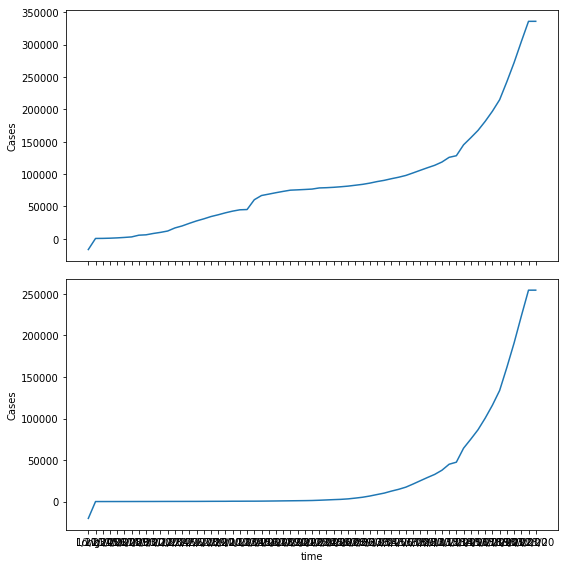

In [4]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

axs[0].plot(ts_confirmed_new.sum()[2:])
axs[0].set_ylabel("Cases")
axs[1].set_ylabel("Cases")
axs[1].set_xlabel("time")
# axs[1].grid(True)
# axs[1].set_yscale("log")
# axs[0].set_yscale("log")

axs[1].plot(ts_confirmed_new[ts_confirmed_new["Country/Region"] != "China"].sum()[2:])
fig.tight_layout()

On remarque clairement que nous le reste du monde entre dans la phase exponentiel

## Construction des series temporels des cas confirmés 

In [9]:
f_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "France"].iloc[0][
    4:
]

i_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Italy"].sum(axis=0)[4:]

c_confirmed = ts_confirmed_new[
    ts_confirmed_new["Country/Region"] == "China"
].sum(axis=0)[4:]
sg_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Singapore"].sum(
    axis=0
)[4:]
ger_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Germany"].sum(
    axis=0
)[4:]
sp_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Spain"].sum(
    axis=0
)[4:]
skorea_confirmed = ts_confirmed_new[
    ts_confirmed_new["Country/Region"] == "Korea, South"
].sum(axis=0)[4:]

taiwan_confirmed = ts_confirmed_new[
    ts_confirmed_new["Country/Region"] == "Taiwan*"
].sum(axis=0)[4:]
us_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "US"].sum(axis=0)[4:]
moro_confirmed=ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Morocco"].iloc[0][4:]

moro_confirmed.index=pd.to_datetime(moro_confirmed.index)

us_confirmed.index = pd.to_datetime(f_confirmed.index)
us_confirmed.name ='US'

f_confirmed.index = pd.to_datetime(f_confirmed.index)
f_confirmed.name ='France'

i_confirmed.index = pd.to_datetime(i_confirmed.index)
i_confirmed.name='Italy'
c_confirmed.index = pd.to_datetime(c_confirmed.index)
sg_confirmed.index = pd.to_datetime(sg_confirmed.index)
sp_confirmed.index = pd.to_datetime(sp_confirmed.index)
sp_confirmed.name='Spain'
ger_confirmed.index = pd.to_datetime(ger_confirmed.index)
ger_confirmed.name='Germany'
skorea_confirmed.index = pd.to_datetime(skorea_confirmed.index)
taiwan_confirmed.index = pd.to_datetime(taiwan_confirmed.index)

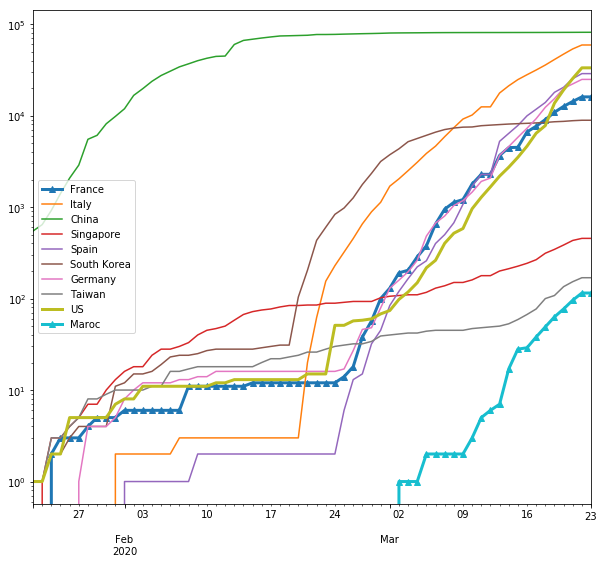

In [10]:
fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale("log")

f_confirmed.plot(label="France", marker="^",linewidth=3)
i_confirmed.plot(label="Italy")
c_confirmed.plot(label="China")
sg_confirmed.plot(label="Singapore")
sp_confirmed.plot(label="Spain")
skorea_confirmed.plot(label="South Korea")
ger_confirmed.plot(label="Germany")
taiwan_confirmed.plot(label="Taiwan")
us_confirmed.plot(label='US',linewidth=3)
moro_confirmed.plot(label='Maroc',marker="^",linewidth=3)
plt.legend(loc="best")

## Delta des cas (chaque 2 jours)

In [11]:
df =pd.DataFrame([us_confirmed.diff()[20:],i_confirmed.diff()[20:],sp_confirmed.diff()[20:],f_confirmed.diff()[20:]]).transpose()

df_resampled=df.resample('2D',label='right',closed='right').sum()

Text(0.5, 1.0, 'Delta des cas chaque 2 jours')

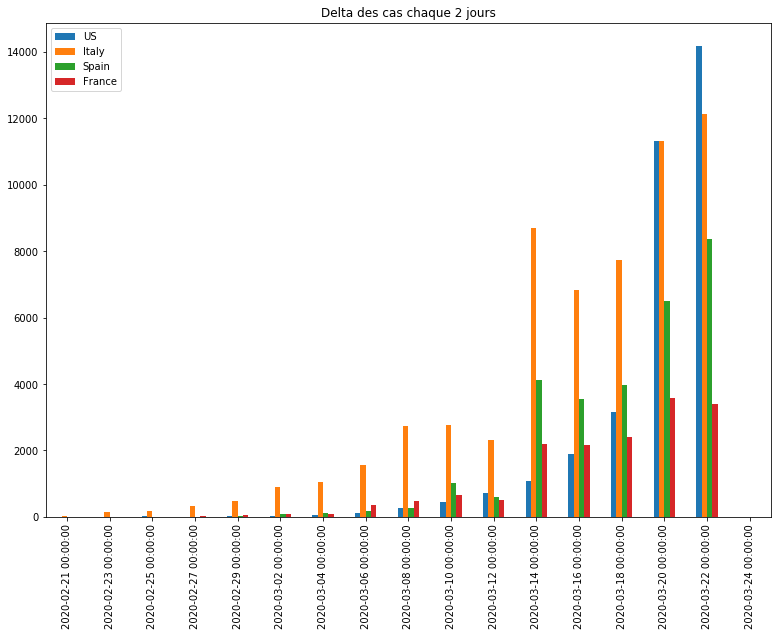

In [12]:
fig = plt.figure(figsize=(13,20))
ax = fig.add_subplot(2, 1, 1)
#ax.set_yscale("log")
df_resampled['2020-02-21':].plot.bar(ax=ax,rot=90)
ax.set_title('Delta des cas chaque 2 jours')

## Accélération des cas

Le facteur de changement de la courbe est égal au ratio de nouveaux cas détéctés entredeux jours. Autrement dit, c'est le ratio de la différence de nombres de cas détectés entre deux jours successifs

In [13]:
f_confirmed_new = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "France"].sum(axis=0)[10:]
f_confirmed_new.index = pd.to_datetime(f_confirmed_new.index)

In [14]:
def growth(serie):
    g = []
    index = []
    for i in range(len(serie)-1):
        if serie.diff()[i] == 0:
            g.append(0)
        else:
            g.append(serie.diff()[i + 1] / serie.diff()[i])
        index.append(serie.index[i])
    return pd.Series(data=g, index=index).replace([np.inf, -np.inf], np.nan).fillna(0)

La moyenne d accélération mondiale : 1.468828300382497


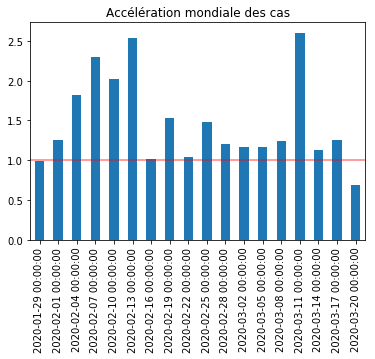

In [15]:
ax= plt.gca()
world_growth =growth(ts_confirmed_new[ts_confirmed_new["Country/Region"] != "China"].sum()[10:])
world_growth.index=pd.to_datetime(world_growth.index)
world_growth= world_growth.resample('3D').mean()
world_growth.plot.bar(ax=ax,rot=90)
ax.axhline(y=1, color="red", alpha=0.5)
ax.set_title('Accélération mondiale des cas')
print('La moyenne d accélération mondiale :',world_growth.mean())

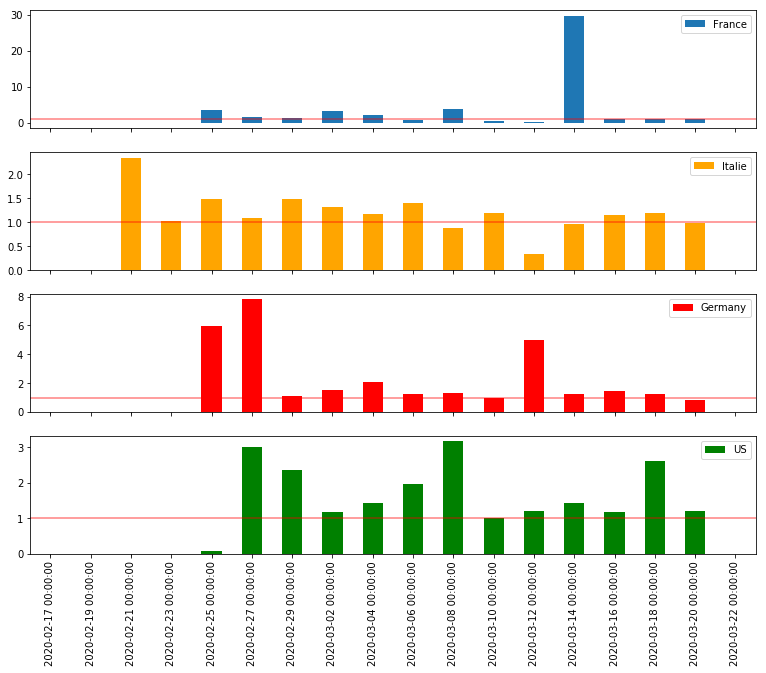

In [24]:
fig, ax = plt.subplots(4, 1, figsize=(13, 10),sharex=True)

growth(f_confirmed_new['2020-02-17':]).resample('2D').mean().plot.bar(ax=ax[0], label="France",rot=90)
f_grow =growth(f_confirmed_new['2020-02-17':]).resample('2D').mean()

growth(i_confirmed['2020-02-17':]).resample('2D').mean().plot.bar(ax=ax[1], label="Italie",color='orange',rot=90)
growth(ger_confirmed['2020-02-17':]).resample('2D').mean().plot.bar(ax=ax[2], label="Germany",color='red',rot=90)
growth(us_confirmed['2020-02-17':]).resample('2D').mean().plot.bar(ax=ax[3], label="US",color='Green',rot=90)


ax[0].legend(loc="best")

ax[0].axhline(y=1, color="red", alpha=0.5)

ax[1].legend(loc="best")
ax[1].axhline(y=1, color="red", alpha=0.5)

ax[2].legend(loc="best")
ax[2].axhline(y=1, color="red", alpha=0.5)

ax[3].legend(loc="best")
ax[3].axhline(y=1, color="red", alpha=0.5)


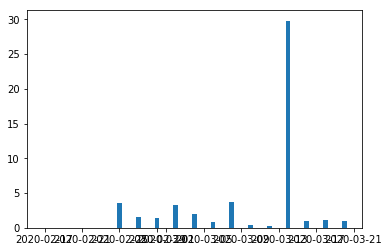

In [64]:
f_grow =growth(f_confirmed_new['2020-02-17':]).resample('2D').mean()
#f_grow.plot.bar(ax=ax[0], label="France",rot=90)

fig, ax = plt.subplots()
bars = ax.bar(f_grow.index,f_grow.values, width=0.5, align="center")


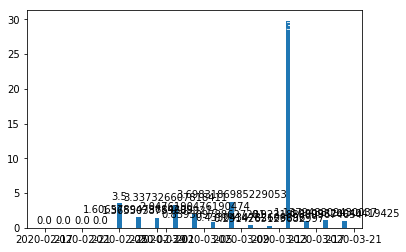

In [76]:
def label_bars(ax, bars, text_format, **kwargs):
    """
    Attaches a label on every bar of a regular or horizontal bar chart
    """
    ys = [bar.get_y() for bar in bars]
    y_is_constant = all(y == ys[0] for y in ys)  # -> regular bar chart, since all all bars start on the same y level (0)

    if y_is_constant:
        _label_bar(ax, bars, text_format, **kwargs)
    else:
        _label_barh(ax, bars, text_format, **kwargs)


def _label_bar(ax, bars, text_format, **kwargs):
    """
    Attach a text label to each bar displaying its y value
    """
    max_y_value = ax.get_ylim()[1]
    inside_distance = max_y_value * 0.05
    outside_distance = max_y_value * 0.01

    for bar in bars:
        text = text_format.format(bar.get_height())
        text_x = bar.get_x() + bar.get_width() / 2

        is_inside = bar.get_height() >= max_y_value * 0.15
        if is_inside:
            color = "white"
            text_y = bar.get_height() - inside_distance
        else:
            color = "black"
            text_y = bar.get_height() + outside_distance

        ax.text(text_x, text_y, text, ha='center', va='bottom', color=color, **kwargs)


def _label_barh(ax, bars, text_format, **kwargs):
    """
    Attach a text label to each bar displaying its y value
    Note: label always outside. otherwise it's too hard to control as numbers can be very long
    """
    max_x_value = ax.get_xlim()[1]
    distance = max_x_value * 0.0025

    for bar in bars:
        text = text_format.format(bar.get_width())

        text_x = bar.get_width() + distance
        text_y = bar.get_y() + bar.get_height() / 2

        ax.text(text_x, text_y, text, va='center', **kwargs)

        
fig, ax = plt.subplots()
bars = ax.bar(f_grow.index,f_grow.values, width=0.5, align="center")

value_format = "{:}"  # displaying values as percentage with one fractional digit

label_bars(ax, bars, value_format)

In [43]:
growth(f_confirmed['2020-02-17':]).mean()

3.274091866106544

## Ratio du changement

In [44]:
f_confirmed = ts_confirmed[ts_confirmed["Country/Region"] == "France"].sum(axis=0)[10:]
f_confirmed.index = pd.to_datetime(f_confirmed.index)

f_confirmed_new = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "France"].sum(axis=0)[10:]
f_confirmed_new.index = pd.to_datetime(f_confirmed_new.index)

In [45]:
def ratio_change(serie):
    g = []
    index = []
    for i in range(len(serie)):
        if i == 0:
            g.append(1)
        else:
            g.append(serie[i] / serie[i - 1])
        index.append(serie.index[i])
    return pd.Series(data=g, index=index).replace([np.inf, -np.inf], np.nan).fillna(0)

count    54.000000
mean      1.163837
std       0.076700
min       1.000000
25%       1.121552
50%       1.165859
75%       1.206858
max       1.355129
dtype: float64


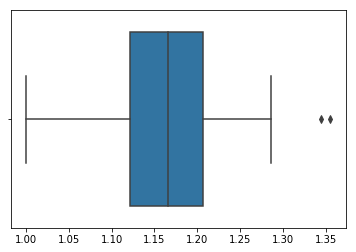

In [46]:
sns.boxplot(
    ratio_change(
        ts_confirmed_new[ts_confirmed_new["Country/Region"] != "China"].sum()[10:]
    )
)
print(
    ratio_change(
        ts_confirmed_new[ts_confirmed_new["Country/Region"] != "China"].sum()[10:]
    ).describe()
)

count    51.000000
mean      1.324716
std       0.845327
min       1.000000
25%       1.000000
50%       1.139448
75%       1.261297
max       6.666667
dtype: float64


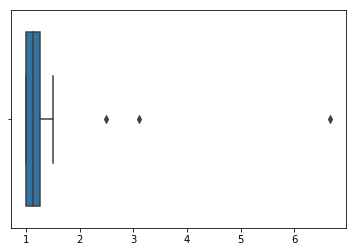

In [47]:
sns.boxplot(ratio_change(i_confirmed[10:]))
print(ratio_change(i_confirmed[10:]).describe())

count    45.000000
mean      1.217102
std       0.269982
min       1.000000
25%       1.000000
50%       1.133978
75%       1.319444
max       2.111111
dtype: float64


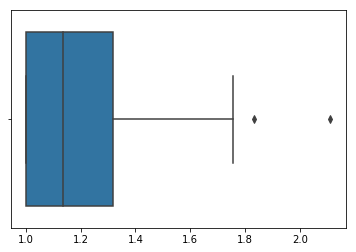

In [48]:
sns.boxplot(ratio_change(f_confirmed_new[10:]))
print(ratio_change(f_confirmed_new[10:]).describe())

Nous remarquons un ratio de changement variant de 1.16 à 1.22 dans le monde, un ratio de 1.18 en moyenne en France avec une plus grance variance(0.27)

Ceci s'explique par le manque de tests généralisés en France.

## Temps pour doubler 

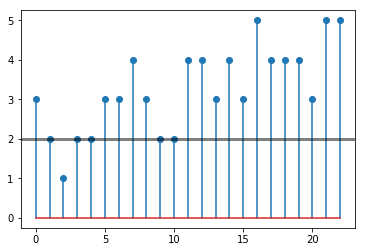

In [49]:
dates = []
index = []
serie = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "France"].sum()[4:]
serie.index = pd.to_datetime(serie.index)
serie = serie["2020-02-24":]

for i in range(len(serie) - 2):
    j = i + 1
    while (j < len(serie) - 1) & (serie[j] < 2 * serie[i]):
        j += 1

    if (j <= len(serie) - 1) & (serie[j] >= 2 * serie[i]):
        dates.append((serie.index[j] - serie.index[i]).days)
        index.append(serie.index[i])

fig, ax = plt.subplots()
plt.stem(pd.Series(data=dates, index=index))
ax.axhline(y=2, linewidth=3, color="black", alpha=0.5)

In [50]:
print("Moyenne pour doubler le chiffre est de ", np.mean(dates))

Moyenne pour doubler le chiffre est de  3.260869565217391


## Comparaison France et Italie

Décaler la courbe des cas de france et d'italie

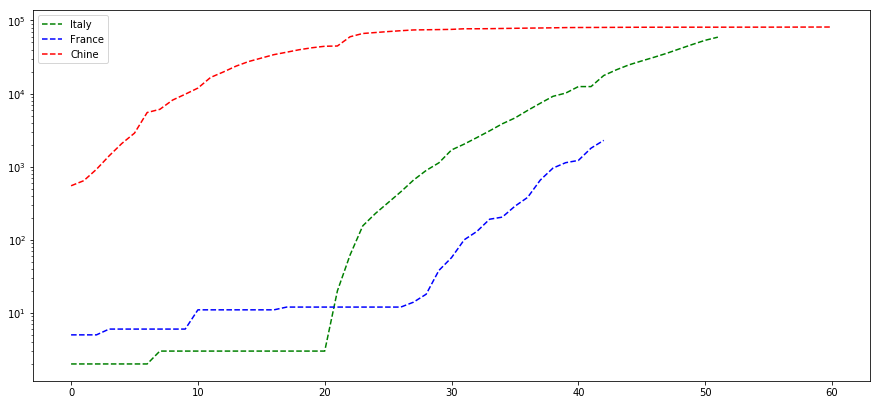

In [51]:
ilist = i_confirmed.where(i_confirmed > 0).dropna().tolist()
flist = f_confirmed_new.where(f_confirmed > 0).dropna().tolist()
Clist = c_confirmed.where(c_confirmed > 0).dropna().tolist()


fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale("log")
ax.plot(ilist, "g--", label="Italy")
ax.plot(flist, "b--", label="France")
ax.plot(Clist, "r--", label="Chine")
plt.legend(loc="upper left")

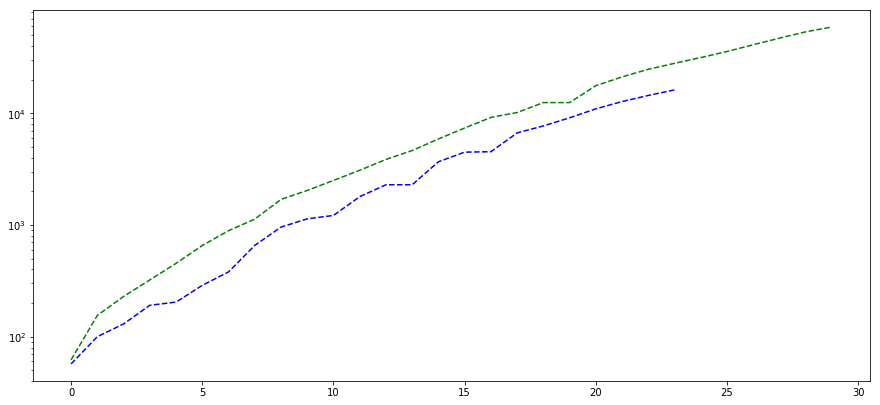

In [52]:
ilist = i_confirmed.where(i_confirmed > 30).dropna().tolist()
flist = f_confirmed_new.where(f_confirmed_new > 40).dropna().tolist()

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale("log")
ax.plot(ilist, "g--", label="Italy")
ax.plot(flist, "b--", label="France")

## Remarques


En décalant les deux courbes pour avoir le même début, nous remarquons que les courbes ont la même forme exponentiel, la France a pu retarder l'évolution des cas de COVID19 un peu plus longtemps de l'Italie mais la progression du virus est visuellement la même; retard de 9 jours

**Comme annoncé par le président de la république Macron, l'épidémie en France ne fait que commencer.**

# LSTM trained on french data

In [77]:
import math
from datetime import timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

## Preparing the data

In [78]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.asarray(X), np.asarray(y)

The training data will be the france confirmed cases till 11 march 2020 

In [79]:
f_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "France"].sum(axis=0)[10:]
f_confirmed.index = pd.to_datetime(f_confirmed.index)

In [80]:
# define input sequence
# choose a number of time steps ( equivalent to # of features)
n_steps = 4

X, y = split_sequence(f_confirmed, n_steps)

## LSTM Model

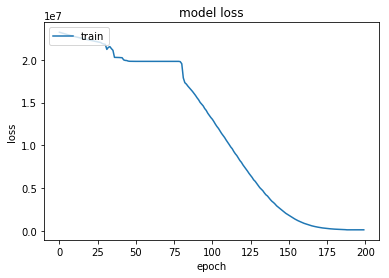

In [81]:
n_features = 1

X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(10, activation="relu", input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")


# fit model
history = model.fit(X, y, epochs=200, verbose=0)

# history for loss
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

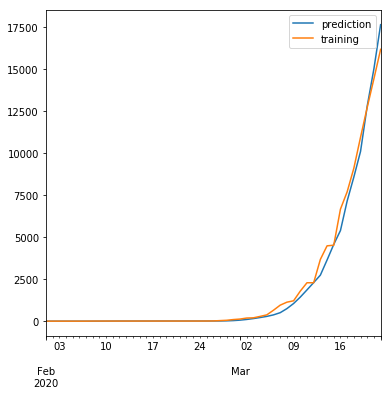

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

pred = model.predict(X)
pred_serie = pd.Series(data=pred.flatten(), index=f_confirmed[4:].index)

pred_serie.plot(ax=ax, label="prediction")
f_confirmed[4:].plot(ax=ax, label="training")

ax.legend(loc="best")

## Prediction

Prédire l'évoltion des cas de COVID19 en France sur le prochains 30 jours

In [84]:
n = 30
index30 = pd.date_range(f_confirmed.index[-1] + timedelta(days=1), periods=n, freq="D")
last_values = f_confirmed[-n_steps:].values
prediction30 = []

In [85]:
for i in range(n):
    x_input = last_values[-n_steps:]
    x_input = x_input.reshape((1, n_steps, n_features))
    y_pred = model.predict(x_input)
    prediction30.append(int(y_pred[0][0]))
    last_values = np.append(last_values, int(y_pred[0][0]))

serie30_france = pd.Series(data=prediction30, index=index30)

Text(2020-03-15, 1000, 'Confinement France')

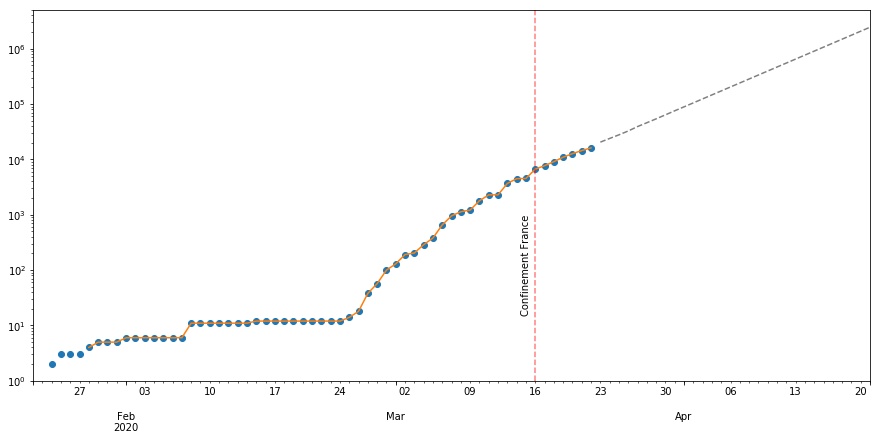

In [86]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 1, 1)

ax.set_yscale("log")

f_confirmed_new = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "France"].sum(
    axis=0
)[4:]
f_confirmed_new.index = pd.to_datetime(f_confirmed_new.index)


f_confirmed_new.plot(ax=ax, label="france_new", marker="o", linestyle="")
f_confirmed.plot(ax=ax, label="france")
# c_confirmed.plot(ax=ax, c="red", label="China")

serie30_france.plot(ax=ax, c="grey", linestyle="--", label="predition for 30 days")

ax.axvline(x='2020-03-16',color='red',linestyle='--',alpha=0.5)
plt.text("2020-03-15", 1000, 'Confinement France',
         rotation=90,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center')

## Intégrer logistique

In [87]:
N_total_france = 67000000  # 67000000

Including a rate of decay of cases of : 1 - Ncase/Ntotal

In [297]:
def logistique(serie):
    g = []
    index = []
    for i in range(len(serie) - 1):
        if i == 0:
            g.append(serie[i])
        else:
            g.append(
                int(
                    serie[i]
                    - (serie[i] / serie[i - 1]) * ((serie[i - 1] ** 2) / N_total_france)
                )
            )
        index.append(serie.index[i])
    return pd.Series(data=g, index=index).replace([np.inf, -np.inf], np.nan).fillna(0)

# LSTM used for South korea

## Prepare train data

In [89]:
# define input sequence
# choose a number of time steps ( equivalent to # of features)
n_steps = 3

X, y = split_sequence(skorea_confirmed[:-1], n_steps)

n_features = 1

# scaler = StandardScaler()
# trainX = scaler.fit_transform(X)
#
# trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))

X = X.reshape((X.shape[0], X.shape[1], n_features))

## Define model

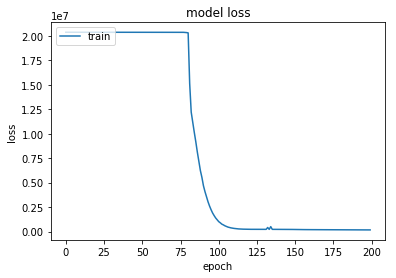

In [96]:
# define model
model = Sequential()
model.add(LSTM(10, activation="relu", input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")


# fit model
history = model.fit(X, y, epochs=200, verbose=0)

# history for loss
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Prediction

In [97]:
n = 100
index30 = pd.date_range(f_confirmed.index[-1] + timedelta(days=1), periods=n, freq="D")
last_values = f_confirmed[-n_steps:].values
prediction30 = []


for i in range(n):
    x_input = last_values[-n_steps:]
    x_input = x_input.reshape((1, n_steps))
    x_input = x_input.reshape((1, n_steps, n_features))
    y_pred = model.predict(x_input)
    prediction30.append(int(y_pred[0][0]))
    last_values = np.append(last_values, int(y_pred[0][0]))

serie30 = pd.Series(data=prediction30, index=index30)

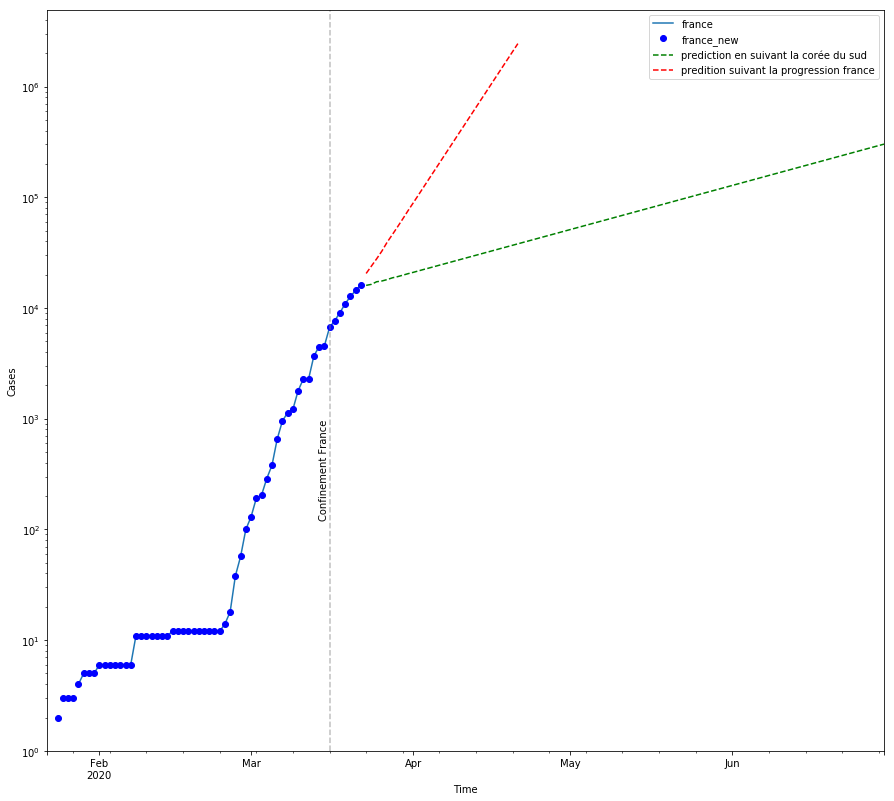

In [98]:
fig = plt.figure(figsize=(15, 30))
ax = fig.add_subplot(2, 1, 1)

ax.set_yscale("log")

f_confirmed.plot(ax=ax, label="france")
f_confirmed_new.plot(ax=ax, label="france_new", marker="o", linestyle="",color='blue')
#skorea_confirmed[10:].plot(ax=ax, marker="^", label="Corée du Sud")

serie30.plot(
    ax=ax, c="green", linestyle="--", label="prediction en suivant la corée du sud"
)


serie30_france.plot(
    ax=ax, c="red", linestyle="--", label="predition suivant la progression france"
)

ax.axvline(x='2020-03-16',color='gray',linestyle='--',alpha=0.5)
plt.text("2020-03-15", 1000, 'Confinement France',
         rotation=90,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center')
ax.set_xlabel("Time")
ax.set_ylabel("Cases")
ax.legend(loc="best")

## Saturation des lits de réanimation dans les hôpitaux

Sachant que la france dispose de 5000 lits sur le territoire et que 5% des cas contaminés par le COVID19 nécessitent un prise en charge hospitalière critique (source : https://jamanetwork.com/journals/jama/fullarticle/2762996).

**Le recours au secteur privé** 
À la demande du gouvernement, le secteur privé, jusque-là en dehors du dispositif, a lui aussi été sollicité. « Dans les premiers temps de l’épidémie, les centres hospitaliers universitaires étaient référents dans la prise en charge. Quand un cas suspect se présentait dans un établissement privé, il était mis en sécurité et à l’isolement pour protéger les patients, puis redirigé vers un CHU pour être soigné », explique Lamine Gharbi, président de la Fédération de l’hospitalisation privée (FHP). Mais on est prêt depuis des semaines, et apportons 4 000 lits disponibles sur le territoire. 

Ce qui nous fait un total 9000 lits

In [99]:
hosp = f_confirmed_new.apply(lambda x: x * 0.05)
hosp_france = serie30_france.apply(lambda x: x * 0.05)
hosp_ks = serie30.apply(lambda x: x * 0.05)

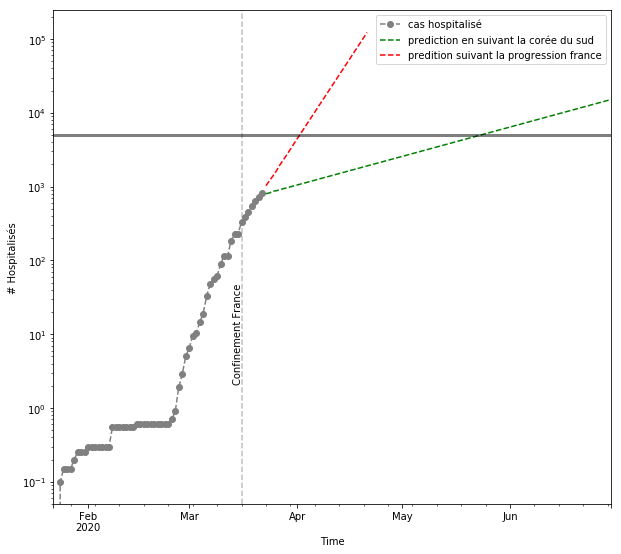

In [100]:
fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale("log")

hosp.plot(ax=ax, c="grey", marker ='o',linestyle="--", label="cas hospitalisé")
hosp_ks.plot(ax=ax, c="green", linestyle="--", label="prediction en suivant la corée du sud")
hosp_france.plot(ax=ax, c="red", linestyle="--", label="predition suivant la progression france")

ax.axvline(x='2020-03-16',color='gray',linestyle='--',alpha=0.5)
plt.text("2020-03-15", 50, 'Confinement France',
         rotation=90,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center')
ax.set_ylabel("# Hospitalisés")
ax.set_xlabel("Time")
ax.legend(loc="best")
ax.axhline(y=5000, linewidth=3, color="black", alpha=0.5)

In [101]:
print(
    "Date de saturation du système hospitalien Francais dans le pire scénario :"
    + hosp_france.where(hosp_france >= 5000).dropna().index[0].strftime("%d/%m/%Y")
)
print(
    "Date de saturation du système hospitalien Francais dans le meilleur scénario :"
    + hosp_ks.where(hosp_ks >= 5000).dropna().index[0].strftime("%d/%m/%Y")
)

Date de saturation du système hospitalien Francais dans le pire scénario :02/04/2020
Date de saturation du système hospitalien Francais dans le meilleur scénario :24/05/2020


In [102]:
ratio_change(serie30_france)

NameError: name 'ratio_change' is not defined